In [1]:
%load_ext autoreload
%autoreload 2
root_dir = r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/"

In [2]:
import sys
import os

# Get the absolute path to the project root
project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'src'))
sys.path.insert(0, os.path.join(project_root, 'utils'))
# project_root = os.path.dirname(r"c:/Users/aagab/codes/Human_pose/new_statistical_coach/")
# print(sys.path)  # Verify the paths are added

In [3]:
from process_yoga_video import process_yoga_video

> Currently, we are getting HOLD phase features after we are sure of holding the pose for 0.5 seconds

SHAPE OF VELOCITY MAGNITUDE: torch.Size([10539, 33])
SHAPE OF SMOOTHED VELOCITY: torch.Size([10539])
Movement detected at frame 1
Hold phase detected at frame 154


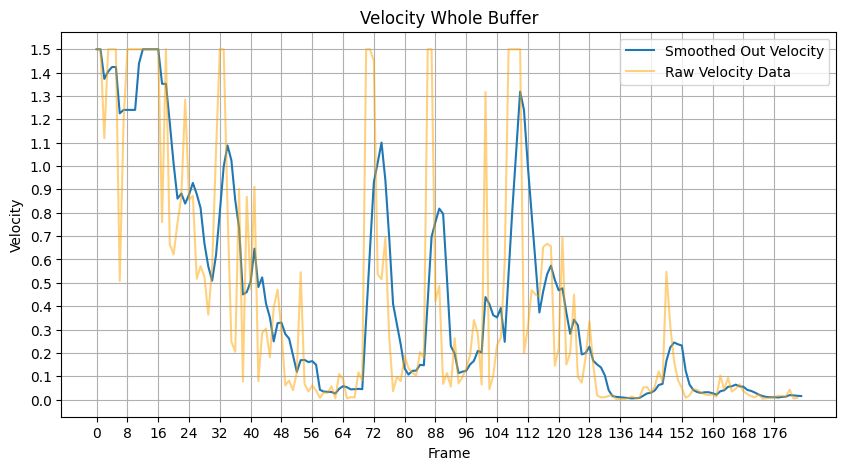

{0: (<PoseState.WAITING: 'waiting'>, 1), 1: (<PoseState.MOVEMENT: 'movement'>, 183), 184: (<PoseState.HOLD: 'hold'>, 0)}


In [4]:
video_path = os.path.join(root_dir, "tiktok_data/mountain/first.mp4")
s = process_yoga_video(video_path)

In [5]:
joint_angle_values = s[1]
joint_angle_values

{0: {'right_shoulder_3d': tensor(175.0714, dtype=torch.float64),
  'left_shoulder_3d': tensor(158.3179, dtype=torch.float64),
  'right_elbow_3d': tensor(151.4132, dtype=torch.float64),
  'left_elbow_3d': tensor(144.9458, dtype=torch.float64),
  'right_hip_3d': tensor(171.7380, dtype=torch.float64),
  'left_hip_3d': tensor(169.5770, dtype=torch.float64),
  'right_knee_3d': tensor(168.1672, dtype=torch.float64),
  'left_knee_3d': tensor(171.6250, dtype=torch.float64),
  'right_ankle_3d': tensor(122.2190, dtype=torch.float64),
  'left_ankle_3d': tensor(127.1717, dtype=torch.float64)},
 1: {'right_shoulder_3d': tensor(175.6122, dtype=torch.float64),
  'left_shoulder_3d': tensor(158.5210, dtype=torch.float64),
  'right_elbow_3d': tensor(151.8397, dtype=torch.float64),
  'left_elbow_3d': tensor(144.7418, dtype=torch.float64),
  'right_hip_3d': tensor(171.8046, dtype=torch.float64),
  'left_hip_3d': tensor(169.7428, dtype=torch.float64),
  'right_knee_3d': tensor(167.9936, dtype=torch.float64

In [6]:
joint_configs = {
        # Upper body
        'right_shoulder': {
            'joints': (13, 11, 23),  # right_elbow, right_shoulder, right_hip
            'joint_names': ('right_elbow', 'right_shoulder', 'right_hip'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_shoulder': {
            'joints': (14, 12, 24),  # left_elbow, left_shoulder, left_hip
            'joint_names': ('left_elbow', 'left_shoulder', 'left_hip'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'right_elbow': {
            'joints': (11, 13, 15),  # right_shoulder, right_elbow, right_wrist
            'joint_names': ('right_shoulder', 'right_elbow', 'right_wrist'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_elbow': {
            'joints': (12, 14, 16),  # left_shoulder, left_elbow, left_wrist
            'joint_names': ('left_shoulder', 'left_elbow', 'left_wrist'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        
        # Lower body
        'right_hip': {
            'joints': (11, 23, 25),  # right_shoulder, right_hip, right_knee
            'joint_names': ('right_shoulder', 'right_hip', 'right_knee'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_hip': {
            'joints': (12, 24, 26),  # left_shoulder, left_hip, left_knee
            'joint_names': ('left_shoulder', 'left_hip', 'left_knee'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'right_knee': {
            'joints': (23, 25, 27),  # right_hip, right_knee, right_ankle
            'joint_names': ('right_hip', 'right_knee', 'right_ankle'),
            'planes': ['sagittal', 'transverse', 'frontal']  # Now including transverse
        },
        'left_knee': {
            'joints': (24, 26, 28),  # left_hip, left_knee, left_ankle
            'joint_names': ('left_hip', 'left_knee', 'left_ankle'),
            'planes': ['sagittal', 'transverse', 'frontal']  # Now including transverse
        },
        'right_ankle': {
            'joints': (25, 27, 31),  # right_knee, right_ankle, right_foot_index
            'joint_names': ('right_knee', 'right_ankle', 'right_foot_index'),
            'planes': ['sagittal', 'transverse', 'frontal']
        },
        'left_ankle': {
            'joints': (26, 28, 32),  # left_knee, left_ankle, left_foot_index
            'joint_names': ('left_knee', 'left_ankle', 'left_foot_index'),
            'planes': ['sagittal', 'transverse', 'frontal']
        }
}

In [7]:
# removes _3d prefix
jav = {}
for k, v in joint_angle_values.items():
    jav[k] = {ik[:-3]: iv for ik, iv in v.items()}

In [8]:
jav[0]
detailed_jav = {}
for k, v in jav[0].items():
    reference_joints = joint_configs[k]['joint_names']
    detailed_jav[k] = (reference_joints, v)
    # print(reference_joints)
    
detailed_jav

{'right_shoulder': (('right_elbow', 'right_shoulder', 'right_hip'),
  tensor(175.0714, dtype=torch.float64)),
 'left_shoulder': (('left_elbow', 'left_shoulder', 'left_hip'),
  tensor(158.3179, dtype=torch.float64)),
 'right_elbow': (('right_shoulder', 'right_elbow', 'right_wrist'),
  tensor(151.4132, dtype=torch.float64)),
 'left_elbow': (('left_shoulder', 'left_elbow', 'left_wrist'),
  tensor(144.9458, dtype=torch.float64)),
 'right_hip': (('right_shoulder', 'right_hip', 'right_knee'),
  tensor(171.7380, dtype=torch.float64)),
 'left_hip': (('left_shoulder', 'left_hip', 'left_knee'),
  tensor(169.5770, dtype=torch.float64)),
 'right_knee': (('right_hip', 'right_knee', 'right_ankle'),
  tensor(168.1672, dtype=torch.float64)),
 'left_knee': (('left_hip', 'left_knee', 'left_ankle'),
  tensor(171.6250, dtype=torch.float64)),
 'right_ankle': (('right_knee', 'right_ankle', 'right_foot_index'),
  tensor(122.2190, dtype=torch.float64)),
 'left_ankle': (('left_knee', 'left_ankle', 'left_foot_i

In [141]:
import torch
from typing import Dict, Tuple, List, Any, Union

ACTION_JOINT_MAPPING = {
    'T_pose': ['right_shoulder', 'left_shoulder', 'right_elbow', 'left_elbow'],
    'warrior_pose': ['right_knee', 'left_knee', 'right_hip', 'left_hip', 'right_ankle', 'left_ankle'],
    'tree_pose': ['right_hip', 'left_hip', 'right_knee', 'left_knee', 'right_ankle', 'left_ankle'],
    'mountain': ['right_ankle', 'left_ankle', 'right_knee', 'left_knee', 'right_hip', 'left_hip', 'right_shoulder', 'left_shoulder']
}

TARGET_ANGLES = {
    'T_pose': {
        'right_shoulder': 180.0,
        'left_shoulder': 180.0,
        'right_elbow': 180.0,
        'left_elbow': 180.0
    },
    'warrior_pose': {
        'right_knee': 90.0,  # Front knee bent at 90 degrees
        'left_knee': 170.0, # Back leg relatively straight, slight bend to avoid hyperextension
        'right_hip': 170.0, # Open hip, but not excessively so
        'left_hip': 170.0,
        'right_ankle': 90.0,
        'left_ankle': 90.0
    },
    'mountain': {
        'right_ankle': 130, 
        'left_ankle': 130,
        'right_knee': 175.0, # Not locked, slight bend to prevent hyperextension
        'left_knee': 175.0,
        'right_hip': 180.0,
        'left_hip': 180.0,
        'right_shoulder': 180.0,
        'left_shoulder': 180.0
    },
    'downward_dog': {
    'right_ankle': 90, # Dorsiflexed
    'left_ankle': 90, # Dorsiflexed
    'right_knee': 175, # Slight bend
    'left_knee': 175, # Slight bend
    'right_hip': 90,
    'left_hip': 90,
    'right_shoulder': 180,
    'left_shoulder': 180
    }
}

def format_angle_data(angle_data: Dict[str, Union[Tuple, torch.Tensor]]) -> Dict[str, float]:
    """
    Convert the raw angle data into a clean dictionary of float values
    """
    formatted_data = {}
    for joint, data in angle_data.items():
        # Check if the data is a tuple (joints, angle) or just an angle
        if isinstance(data, tuple):
            angle = data[1]
        else:
            angle = data
        
        # Convert tensor to float
        if isinstance(angle, torch.Tensor):
            formatted_data[joint] = float(angle)
        else:
            formatted_data[joint] = float(angle)
    
    return formatted_data

def generate_pose_feedback_prompt(
    user_angles: Dict[str, Any],
    target_angles: Dict[str, Any],
    action_type: str,
    joint_configs: Dict[str, Dict[str, Any]]
) -> str:
    """
    Generate a structured prompt for pose feedback
    
    Parameters:
    - user_angles: Dictionary of current user joint angles
    - target_angles: Dictionary of target joint angles
    - action_type: Type of pose/action being performed
    - joint_configs: Configuration dictionary containing joint relationships
    
    Returns:
    - Formatted prompt string
    """
    # Format the angle data
    # print(user_angles)
    user_angles_clean = format_angle_data(user_angles)
    target_angles_clean = format_angle_data(target_angles)
    
    # print("User Angles Clean:", user_angles_clean)
    # print("Target Angles Clean:", target_angles_clean)
    # Get relevant joints for this action
    relevant_joints = ACTION_JOINT_MAPPING.get(action_type, [])
    # print("Relevant Joints:", relevant_joints) 
    # Build the prompt
    # action_type = 'downward dog'
    prompt_parts = [
        f"Action: {action_type} Pose\n",
        "Current Joint Analysis:\n"
    ]
    
    # Add joint-specific information
    for joint in relevant_joints:
        if joint in user_angles_clean and joint in target_angles_clean:
            current_angle = user_angles_clean[joint]
            target_angle = target_angles_clean[joint]
            # print(current_angle)
            
            # Get involved body parts from joint_configs
            involved_parts = joint_configs[joint]['joint_names']
            
            prompt_parts.append(
                f"- {joint.replace('_', ' ').title()}:\n"
                f"  Current: {current_angle:.1f}°\n"
                f"  Target: {target_angle:.1f}°\n"
                f"  Involved parts: {', '.join(involved_parts)}\n"
            )
    
    # Add instruction for the language model
    prompt_parts.extend([
        "\nContext:",
        f"- This is a {action_type.replace('_', ' ')} position",
        "- Angles represent the degree between connected body parts",
        "- 180° represents a straight line\n",
        "Task: Based on these angles, provide clear, simple feedback in 5-10 words",
        "focusing on the most important corrections needed for proper form.",
        "Prioritize larger deviations and maintain bilateral symmetry where appropriate.",
        "Don't use numbers simply use words used by a typical yoga coach or a fitness coach, but use simple words.",
        "Focus only on the most significant flaw, first go though all the deviations and find out one that is affecting the pose most."
    ])
    
    return "\n".join(prompt_parts)

In [142]:

test_data= {
    'right_ankle': 170,  # 90 target
    'left_ankle': 160,    # 90
    'right_knee': 175, 
    'left_knee': 175, 
    'right_hip': 90,
    'left_hip': 90,
    'right_shoulder': 180,
    'left_shoulder': 180
}

In [143]:
prompt = generate_pose_feedback_prompt(detailed_jav, TARGET_ANGLES['mountain'], 'mountain', joint_configs)
print(prompt)

Action: mountain Pose

Current Joint Analysis:

- Right Ankle:
  Current: 122.2°
  Target: 130.0°
  Involved parts: right_knee, right_ankle, right_foot_index

- Left Ankle:
  Current: 127.2°
  Target: 130.0°
  Involved parts: left_knee, left_ankle, left_foot_index

- Right Knee:
  Current: 168.2°
  Target: 175.0°
  Involved parts: right_hip, right_knee, right_ankle

- Left Knee:
  Current: 171.6°
  Target: 175.0°
  Involved parts: left_hip, left_knee, left_ankle

- Right Hip:
  Current: 171.7°
  Target: 180.0°
  Involved parts: right_shoulder, right_hip, right_knee

- Left Hip:
  Current: 169.6°
  Target: 180.0°
  Involved parts: left_shoulder, left_hip, left_knee

- Right Shoulder:
  Current: 175.1°
  Target: 180.0°
  Involved parts: right_elbow, right_shoulder, right_hip

- Left Shoulder:
  Current: 158.3°
  Target: 180.0°
  Involved parts: left_elbow, left_shoulder, left_hip


Context:
- This is a mountain position
- Angles represent the degree between connected body parts
- 180° re

In [118]:
from groq import Groq
from dotenv import load_dotenv
import os

load_dotenv()

def get_llama_feedback(
    user_content, 
    system_content="You are a helpful fitness coach providing precise, constructive feedback.",
    model="llama-3.1-8b-instant", 
    temperature=1, 
    max_completion_tokens=1024, 
    top_p=1
):
    """
    Generate feedback using Groq's Llama API.
    
    Args:
        user_content (str): The main content/prompt to send to the model
        system_content (str, optional): System message to set model context. Defaults to fitness coach prompt.
        model (str, optional): Model to use. Defaults to "llama-3.1-8b-instant".
        temperature (float, optional): Sampling temperature. Defaults to 1.
        max_completion_tokens (int, optional): Maximum tokens in response. Defaults to 1024.
        top_p (float, optional): Nucleus sampling parameter. Defaults to 1.
    
    Returns:
        str: Generated model feedback
    """
    client = Groq(api_key=os.getenv("GROQ_API_KEY"))  

    completion = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system", 
                "content": system_content
            },
            {
                "role": "user", 
                "content": user_content
            }
        ],
        temperature=temperature,
        max_completion_tokens=max_completion_tokens,
        top_p=top_p,
        stream=True,
        stop=None,
    )

    model_feedback = ""
    for chunk in completion:
        content = chunk.choices[0].delta.content or ""
        print(content, end="")
        model_feedback += content
    
    return model_feedback

# # Extract the model's feedback
# model_feedback = response.choices[0].message.content.strip()
# print(model_feedback)


In [119]:
# model_feedback = get_llama_feedback(prompt, temperature=0, model="llama-3.2-3b-preview")
# model_feedback = get_llama_feedback(prompt, temperature=0, model="gemma2-9b-it")
# prompt = "Give me feedback about how to do Mountain pose yoga in 10 words."
model_feedback = get_llama_feedback(prompt, temperature=0)

"Engage your right ankle by slightly lifting your right heel, and maintain equal weight distribution on both feet. Also, focus on opening your left shoulder to match your right."

In [113]:
print(model_feedback)

"Engage your right ankle by slightly lifting your right heel, and maintain equal weight distribution on both feet. Also, focus on opening your left shoulder to match your right."


In [114]:
from text_to_speech import text_to_speech

In [115]:
SAMPLE_RATE = 22050
audio = text_to_speech(model_feedback)
from IPython.display import Audio, display
display(Audio(audio, rate=SAMPLE_RATE))


Generating speech for: '"Engage your right ankle by slightly lifting your right heel, and maintain equal weight distribution on both feet. Also, focus on opening your left shoulder to match your right."'
Debug - Processed phonemes: '"ɛŋɡˈeɪdʒ jʊɹ ɹˈaɪt ˈaeŋkəl baɪ slˈaɪtli lˈɪftɪŋ jʊɹ ɹˈaɪt hˈiːl, aend meɪntˈeɪn ˈiːkwəl wˈeɪt dˌɪstɹɪbjˈuːʃən ˌɔn bˈoʊθ fˈiːt. ˈɔːlsoʊ, fˈoʊkəs ˌɔn ˈoʊpənɪŋ jʊɹ lˈɛft ʃˈoʊldɚ tə mˈaetʃ jʊɹ ɹˈaɪt."'

Audio saved to output.wav
Generated phonemes: "ɛŋɡˈeɪdʒ jʊɹ ɹˈaɪt ˈaeŋkəl baɪ slˈaɪtli lˈɪftɪŋ jʊɹ ɹˈaɪt hˈiːl, aend meɪntˈeɪn ˈiːkwəl wˈeɪt dˌɪstɹɪbjˈuːʃən ˌɔn bˈoʊθ fˈiːt. ˈɔːlsoʊ, fˈoʊkəs ˌɔn ˈoʊpənɪŋ jʊɹ lˈɛft ʃˈoʊldɚ tə mˈaetʃ jʊɹ ɹˈaɪt."


In [160]:
import requests

def get_language_model_feedback(
    user_content, 
    system_content="You are a helpful fitness coach providing precise, constructive feedback.",
    model="local-model", 
    temperature=0, 
    max_tokens=1024, 
    top_p=1,
    base_url="http://localhost:1234/v1"
):
    """
    Generate feedback using LM Studio's local server.
    
    Args:
        user_content (str): The main content/prompt to send to the model
        system_content (str, optional): System message to set model context. 
        model (str, optional): Model identifier. Defaults to "local-model".
        temperature (float, optional): Sampling temperature. Defaults to 1.
        max_tokens (int, optional): Maximum tokens in response. Defaults to 1024.
        top_p (float, optional): Nucleus sampling parameter. Defaults to 1.
        base_url (str, optional): Base URL for LM Studio server. Defaults to local endpoint.
    
    Returns:
        str: Generated model feedback
    """
    try:
        # Prepare the payload for the API request
        payload = {
            "messages": [
                {"role": "system", "content": system_content},
                {"role": "user", "content": user_content}
            ],
            "temperature": temperature,
            "max_tokens": max_tokens,
            "top_p": top_p,
            "model": model
        }

        # Send POST request to LM Studio server
        response = requests.post(
            f"{base_url}/chat/completions", 
            json=payload
        )

        # Check if the request was successful
        response.raise_for_status()

        # Extract and return the model's response
        model_response = response.json()
        model_feedback = model_response['choices'][0]['message']['content'].strip()

        # Optional: Print the feedback as it's generated
        print(model_feedback)
        
        return model_feedback

    except requests.RequestException as e:
        print(f"Error communicating with LM Studio server: {e}")
        return ""

# Example usage remains the same

In [161]:

model_feedback = get_language_model_feedback(prompt)

Right ankle needs to be more extended.


In [162]:
SAMPLE_RATE = 22050
audio = text_to_speech(model_feedback)
from IPython.display import Audio, display
display(Audio(audio, rate=SAMPLE_RATE))


Generating speech for: 'Right ankle needs to be more extended.'
Debug - Processed phonemes: 'ɹˈaɪt ˈaeŋkəl nˈiːdz təbi mˈɔːɹ ɛkstˈɛndᵻd.'

Audio saved to output.wav
Generated phonemes: ɹˈaɪt ˈaeŋkəl nˈiːdz təbi mˈɔːɹ ɛkstˈɛndᵻd.


In [140]:
# prompt = "DO merge sort in rust"
model_feedback = get_language_model_feedback(prompt)

KeyboardInterrupt: 

In [163]:
def generate_pose_feedback_prompt(
    user_angles: Dict[str, Any],
    target_angles: Dict[str, Any],
    action_type: str,
    joint_configs: Dict[str, Dict[str, Any]]
) -> str:
    """
    Generate a structured prompt for pose feedback
    
    Parameters:
    - user_angles: Dictionary of current user joint angles
    - target_angles: Dictionary of target joint angles
    - action_type: Type of pose/action being performed
    - joint_configs: Configuration dictionary containing joint relationships
    
    Returns:
    - Formatted prompt string
    """
    # Format the angle data
    user_angles_clean = format_angle_data(user_angles)
    target_angles_clean = format_angle_data(target_angles)
    
    # Get relevant joints for this action
    relevant_joints = ACTION_JOINT_MAPPING.get(action_type, [])
    
    # Build the prompt
    prompt_parts = [
        f"Action: {action_type} Pose\n",
        "Current Joint Analysis:\n"
    ]
    
    # Add joint-specific information
    for joint in relevant_joints:
        if joint in user_angles_clean and joint in target_angles_clean:
            current_angle = user_angles_clean[joint]
            target_angle = target_angles_clean[joint]
            
            # Get involved body parts from joint_configs
            involved_parts = joint_configs[joint]['joint_names']
            
            prompt_parts.append(
                f"- {joint.replace('_', ' ').title()}:\n"
                f"  Current: {current_angle:.1f}°\n"
                f"  Target: {target_angle:.1f}°\n"
                f"  Involved parts: {', '.join(involved_parts)}\n"
            )
    
    # Add detailed instructions for feedback generation
    prompt_parts.extend([
        "\nContext:",
        f"- This is a {action_type.replace('_', ' ')} pose, requiring specific alignment.",
        "- Angles indicate the degree of alignment between connected body parts.",
        "- 180° represents a straight alignment; deviations suggest misalignment.",
        "- The focus is on identifying the single most significant misalignment.",
        "\nTask:",
        "- Evaluate the angles provided and identify the most significant issue affecting the pose.",
        "- Use clear, simple feedback as a yoga or fitness coach would.",
        "- Avoid numerical feedback; instead, describe adjustments in plain language.",
        "- Prioritize fixing the most impactful flaw first and maintaining bilateral symmetry.",
        "- Suggest corrections concisely in 5-10 words."
    ])
    
    return "\n".join(prompt_parts)


In [164]:

prompt = generate_pose_feedback_prompt(detailed_jav, TARGET_ANGLES['mountain'], 'mountain', joint_configs)
print(prompt)

Action: mountain Pose

Current Joint Analysis:

- Right Ankle:
  Current: 122.2°
  Target: 130.0°
  Involved parts: right_knee, right_ankle, right_foot_index

- Left Ankle:
  Current: 127.2°
  Target: 130.0°
  Involved parts: left_knee, left_ankle, left_foot_index

- Right Knee:
  Current: 168.2°
  Target: 175.0°
  Involved parts: right_hip, right_knee, right_ankle

- Left Knee:
  Current: 171.6°
  Target: 175.0°
  Involved parts: left_hip, left_knee, left_ankle

- Right Hip:
  Current: 171.7°
  Target: 180.0°
  Involved parts: right_shoulder, right_hip, right_knee

- Left Hip:
  Current: 169.6°
  Target: 180.0°
  Involved parts: left_shoulder, left_hip, left_knee

- Right Shoulder:
  Current: 175.1°
  Target: 180.0°
  Involved parts: right_elbow, right_shoulder, right_hip

- Left Shoulder:
  Current: 158.3°
  Target: 180.0°
  Involved parts: left_elbow, left_shoulder, left_hip


Context:
- This is a mountain pose, requiring specific alignment.
- Angles indicate the degree of alignment

In [165]:
model_feedback = get_language_model_feedback(prompt)

Your right hip is slightly off center.  Bring your right hip forward to align with your left.


In [166]:
SAMPLE_RATE = 22050
audio = text_to_speech(model_feedback)
from IPython.display import Audio, display
display(Audio(audio, rate=SAMPLE_RATE))


Generating speech for: 'Your right hip is slightly off center.  Bring your right hip forward to align with your left.'
Debug - Processed phonemes: 'jʊɹ ɹˈaɪt hˈɪp ɪz slˈaɪtli ˈɔf sˈɛntɚ. bɹˈɪŋ jʊɹ ɹˈaɪt hˈɪp fˈɔːɹwɚd tʊ ɐlˈaɪn wɪð jʊɹ lˈɛft.'

Audio saved to output.wav
Generated phonemes: jʊɹ ɹˈaɪt hˈɪp ɪz slˈaɪtli ˈɔf sˈɛntɚ. bɹˈɪŋ jʊɹ ɹˈaɪt hˈɪp fˈɔːɹwɚd tʊ ɐlˈaɪn wɪð jʊɹ lˈɛft.
